In [1]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

In [2]:
ALGOS = ["rf", "lda", "pca"]
ALGO_NAMES = ["RF", "LDA RF", "PCA RF"]

# Total CPU Time

In [3]:
df_comparison = pd.read_csv("comparison.csv")

In [4]:
cpu_hours = sum(df_comparison["traintime_total_max"]) / 3600
cpu_days = cpu_hours / 24
print(cpu_hours, "hours")
print(cpu_days, "days")

1402.9988580555557 hours
58.45828575231482 days


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/home/felix/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


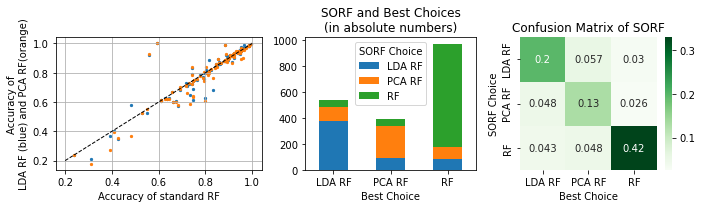

In [5]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(10,3),  gridspec_kw={'width_ratios': [1.2, 1, 1]})
ct = pd.crosstab(df_comparison["best_choice_test"], df_comparison.rename(columns={"choice": "SORF Choice"})["SORF Choice"])

permutation = [1, 2, 0]

# plot comparison of RF against LDA RF and PCA RF
df_rfcomparison = df_comparison.groupby("openmlid")["rf_test", "lda_test", "pca_test"].mean()
ax[0].scatter(df_rfcomparison["rf_test"], df_rfcomparison["lda_test"], color="C0", s=5)
ax[0].scatter(df_rfcomparison["rf_test"], df_rfcomparison["pca_test"], color="C1", s=5)
ax[0].plot([0.2,1], [0.2,1], linewidth=1, linestyle="--", color="black")
ax[0].grid()
ax[0].set_xlabel("Accuracy of standard RF")
ax[0].set_ylabel("Accuracy of\nLDA RF (blue) and PCA RF(orange)")

ct = ct.rename(columns={a: n for a, n in zip(ALGOS, ALGO_NAMES)})
ct.plot(kind='bar', stacked=True, rot=0, ax=ax[1])
ct_normalized = ct.values / np.sum(ct.values)
sns.heatmap(ct_normalized, annot=True, ax = ax[2], vmax=0.33, cmap="Greens")
for a in ax[1:]:
    a.set_xlabel("Best Choice")
ax[1].set_xticklabels([ALGO_NAMES[i] for i in permutation])
ax[1].set_title("SORF and Best Choices\n(in absolute numbers)")

ax[2].set_ylabel("SORF Choice")
ax[2].set_xticklabels([ALGO_NAMES[i] for i in permutation])
ax[2].set_yticklabels([ALGO_NAMES[i] for i in permutation])
ax[2].set_title("Confusion Matrix of SORF")
fig.tight_layout()
fig.savefig("plots/confusion.pdf", bbox_inches='tight')

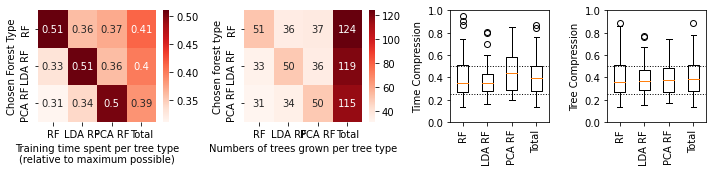

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(10, 2.5),  gridspec_kw={'width_ratios': [1.5, 1.5, 1, 1]})

Z = []
for i, a_choice in enumerate(ALGOS):
    df_selection = df_comparison[(df_comparison["choice"] == a_choice)]
    Z.append([np.mean(df_selection["traintime_" + a_tree + "_act"] / df_selection["traintime_" + a_tree + "_max"]) for a_tree in ALGOS])
Z = np.array(Z)
Z = np.column_stack([Z, np.sum(Z, axis=1) / 3])

ax = axes[0]
sns.heatmap(Z, annot=True, ax = ax, cmap="Reds")
ax.set_xticklabels(ALGO_NAMES + ["Total"])
ax.set_yticklabels(ALGO_NAMES)
ax.set_ylabel("Chosen Forest Type")
ax.set_xlabel("Training time spent per tree type\n(relative to maximum possible)")

Z = []
for i, a_choice in enumerate(ALGOS):
    df_selection = df_comparison[(df_comparison["choice"] == a_choice)]
    Z.append([int(np.round(np.mean(df_selection["trees_" + a_tree]))) for a_tree in ALGOS])
Z = np.array(Z,dtype=int)
Z = np.column_stack([Z, np.sum(Z, axis=1)])
ax = axes[1]
sns.heatmap(Z, annot=True, ax = ax, cmap="Reds", fmt='g')
ax.set_xticklabels(ALGO_NAMES + ["Total"])
ax.set_yticklabels(ALGO_NAMES)
ax.set_ylabel("Chosen forest type")
ax.set_xlabel("Numbers of trees grown per tree type")




compressions_in_time = [[np.mean(g["time_compression"]) for i, g in df_comparison[df_comparison["choice"] == a].groupby("openmlid")] for a in ALGOS] + [[np.mean(g["time_compression"]) for i, g in df_comparison.groupby("openmlid")]]
compressions_in_num_trees = [[np.mean(g["tree_compression"]) for i, g in df_comparison[df_comparison["choice"] == a].groupby("openmlid")] for a in ALGOS] + [[np.mean(g["tree_compression"]) for i, g in df_comparison.groupby("openmlid")]]

for a, values in zip(axes[2:], [compressions_in_time, compressions_in_num_trees]):
    a.boxplot(values)
    a.set_ylim([0, 1])
    a.set_xticklabels(ALGO_NAMES + ["Total"], rotation=90)
    a.axhline(0.5, linestyle="dotted", color="black", linewidth=1)
    a.axhline(0.25, linestyle="dotted", color="black", linewidth=1)
    a.axvline(4.5, color="black", linewidth=1)
axes[2].set_ylabel("Time Compression")
axes[3].set_ylabel("Tree Compression")

fig.tight_layout()
fig.savefig("plots/computations.pdf", bbox_inches='tight')
plt.show()

/home/felix/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/felix/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


-0.0010137171052631555


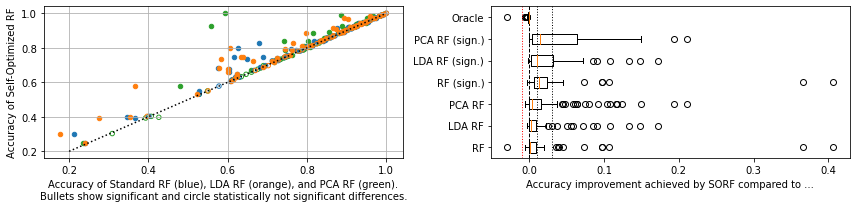

In [48]:
def get_performance_figure_and_table_for_paper(df_comparison):
    
    
    algo_names = ["rf", "lda", "pca"]
    
    scores = []
    significances_with_sorf = {a : [] for a in algo_names}
    significances_with_best = {a : [] for a in algo_names}
    
    imps = []
    
    rows = []
    for openmlid, df_dataset in df_comparison.groupby("openmlid"):
        
        # extract the scores of the algorithms on this dataset
        perf_selfopt = df_dataset["selfopt_test"]
        data_base = []
        for comp in algo_names:
            perf_comp = df_dataset[comp + "_test"]
            data_base.append(perf_comp)
            if np.linalg.norm(perf_comp - perf_selfopt) != 0:
                significant = scipy.stats.wilcoxon(perf_comp, perf_selfopt).pvalue < 0.05
            else:
                significant = False
            significances_with_sorf[comp].append(significant)
        data_base.append(perf_selfopt)


        # compute mean scores of the algorithms on dataset
        scores_on_dataset = [np.mean(v) for v in data_base]
        imps_on_dataset = [scores_on_dataset[-1] - v for v in scores_on_dataset]
        scores.append(scores_on_dataset)
        imps.append(imps_on_dataset)
        best_score = max(scores_on_dataset)
        best_indices = [i for i in range(len(data_base)) if scores_on_dataset[i] == best_score]
        
        
        # determine significant differences to best
        best_algo = (algo_names + ["selfopt"])[np.argmax(scores_on_dataset)]
        perf_best = df_dataset[best_algo + "_test"]
        for comp in algo_names:
            perf_comp = df_dataset[comp + "_test"]
            if np.linalg.norm(perf_comp - perf_best) != 0:
                significant = scipy.stats.wilcoxon(perf_comp, perf_best).pvalue < 0.05
            else:
                significant = False
            significances_with_best[comp].append(significant)
        
        
        # format entries
        formatted_vals = [f"{np.round(100 * np.mean(v), 2)}$\pm${np.round(100 * np.std(v), 1)}" for i, v in enumerate(data_base)]
        #imps.append(scores_on_dataset[1] - scores_on_dataset[0])
        for i, val in enumerate(formatted_vals):
            if i in best_indices:
                formatted_vals[i] = "\\textbf{" + val + "}"
            elif not significant:
                formatted_vals[i] = "\\underline{" + val + "}"

        rows.append([openmlid] + formatted_vals)
    
    scores = np.array(scores)
    imps = np.array(imps)
    
    for a in algo_names:
        significances_with_sorf[a] = np.array(significances_with_sorf[a])
        significances_with_best[a] = np.array(significances_with_best[a])
    
    
    colors = {
        "rf": "C2",
        "lda": "C0",
        "pca": "C1"
    }
    
    
    
    # create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3),  gridspec_kw={'width_ratios': [1, 1]})
    
    
    for i, a in enumerate(["rf", "lda", "pca"]):
        ax1.scatter(scores[significances_with_sorf[a],i], scores[significances_with_sorf[a],-1], s=20, color=colors[a])
        ax1.scatter(scores[~significances_with_sorf[a],i], scores[~significances_with_sorf[a],-1], s=20, facecolors="None", color=colors[a])
    
    ax1.plot([0.2,1], [0.2,1], linestyle="dotted", color="black")
    ax1.grid()
    ax1.set_xlabel("Accuracy of Standard RF (blue), LDA RF (orange), and PCA RF (green).\nBullets show significant and circle statistically not significant differences.")
    ax1.set_ylabel("Accuracy of Self-Optimized RF")
    
    imp_concated = []
    for i, algo in enumerate(algo_names):
        imp_concated.append(imps[:,i])
    for i, algo in enumerate(algo_names):
        imp_concated.append(imps[significances_with_sorf[algo],i])
    
    imp_concated.append(np.min(imps, axis=1))
    
    ax2.boxplot(imp_concated, vert=False)
    ax2.axvline(-0.01, linestyle="dotted", color="red", linewidth=1)
    ax2.axvline(0, linestyle="--", color="black", linewidth=1)
    ax2.axvline(0.01, linestyle="dotted", color="black", linewidth=1)
    ax2.axvline(0.03, linestyle="dotted", color="black", linewidth=1)
    ax2.set_xlabel("Accuracy improvement achieved by SORF compared to ...")
    ax2.set_yticklabels(ALGO_NAMES + [name + " (sign.)" for name in ALGO_NAMES] + ["Oracle"])
    #ax2.scatter(list(range(len(imps))), imps)
    #ax2.hist(imps, bins=200)
    #ax2.set_yscale("log")
    fig.tight_layout()
    
    print(np.mean(imp_concated[-1]))
    
    return (fig, ax), pd.DataFrame(rows, columns=["openmlid"] + ALGO_NAMES + ["SORF"])
    
(fig, ax), df_results = get_performance_figure_and_table_for_paper(df_comparison)
fig.savefig("plots/performance.pdf", bbox_inches='tight')
plt.show()

In [27]:
print(df_results.head(48).to_latex(index = False, escape = False))

\begin{tabular}{rllll}
\toprule
 openmlid &                         RF &                     LDA RF &                     PCA RF &                       SORF \\
\midrule
        3 &               97.2$\pm$0.2 &     \textbf{97.52$\pm$0.3} &              97.03$\pm$0.3 &              97.35$\pm$0.4 \\
        6 &  \underline{94.08$\pm$0.1} &  \underline{94.95$\pm$0.1} &     \textbf{95.03$\pm$0.1} &  \underline{95.02$\pm$0.1} \\
       11 &  \underline{85.44$\pm$0.8} &     \textbf{89.35$\pm$0.9} &  \underline{89.03$\pm$0.9} &  \underline{89.29$\pm$1.1} \\
       12 &              95.28$\pm$0.4 &      \textbf{97.1$\pm$0.3} &              96.73$\pm$0.4 &              97.09$\pm$0.4 \\
       13 &     \textbf{73.12$\pm$1.5} &  \underline{72.63$\pm$1.7} &  \underline{72.81$\pm$1.9} &  \underline{73.06$\pm$1.7} \\
       23 &              52.81$\pm$1.2 &              52.78$\pm$1.2 &              52.37$\pm$1.4 &     \textbf{53.04$\pm$1.3} \\
       30 &   \underline{91.9$\pm$1.5} &  \underline{91.

In [28]:
print(df_results.tail(48).to_latex(index = False, escape = False))

\begin{tabular}{rllll}
\toprule
 openmlid &                         RF &                     LDA RF &                     PCA RF &                       SORF \\
\midrule
     1487 &     \textbf{93.72$\pm$0.3} &     \textbf{93.72$\pm$0.3} &     \textbf{93.72$\pm$0.3} &     \textbf{93.72$\pm$0.3} \\
     1488 &  \underline{87.87$\pm$1.6} &  \underline{88.21$\pm$1.0} &  \underline{88.23$\pm$1.3} &     \textbf{88.67$\pm$1.1} \\
     1489 &  \underline{88.17$\pm$0.3} &  \underline{88.55$\pm$0.3} &  \underline{88.58$\pm$0.3} &     \textbf{88.59$\pm$0.3} \\
     1494 &              85.86$\pm$0.8 &     \textbf{87.06$\pm$0.6} &              86.63$\pm$0.7 &              86.89$\pm$0.7 \\
     1499 &  \underline{90.53$\pm$1.1} &  \underline{91.67$\pm$1.3} &  \underline{91.49$\pm$1.4} &     \textbf{91.86$\pm$1.3} \\
     1515 &     \textbf{83.06$\pm$1.5} &              67.94$\pm$2.1 &              76.34$\pm$1.4 &              82.75$\pm$2.0 \\
     1566 &  \underline{59.35$\pm$1.2} &     \textbf{100

# Datasets With Properties

In [38]:
import openml
from tqdm.notebook import tqdm

datasets = [int(i) for i in sorted(pd.unique(df_results["openmlid"]))]
rows = []
for openmlid in tqdm(datasets):
    
    # load dataset object
    dataset = openml.datasets.get_dataset(openmlid)
    
    # analyze columns of data
    if False:
        dfDataset = dataset.get_data()[0]
        types = dfDataset.dtypes
        cnt_normalized = 0
        cnt_zero_mean = 0
        cnt_one_std = 0
        cnt_numerical = 0
        for i, col in enumerate(dfDataset.columns):
            if "float" in str(types[i]):
                cnt_numerical += 1
                vals = dfDataset[col].values
                is_normalized = np.round(min(vals), 3) == 0 and np.round(max(vals), 3) == 1
                is_zero_mean = np.round(np.mean(vals), 3) == 0
                is_one_std = np.round(np.std(vals), 3) == 1
                if is_normalized:
                    cnt_normalized += 1
                if is_zero_mean:
                    cnt_zero_mean += 1
                if is_one_std:
                    cnt_one_std += 1
        if cnt_numerical > 0:
            feature_stats_entries = [str(v) + "\%" for v in np.round(100 * np.array([cnt_normalized / cnt_numerical, cnt_zero_mean / cnt_numerical, cnt_one_std / cnt_numerical]), 0).astype(int)]
        else:
            feature_stats_entries = 3 * ["n/a"]
    
    
    num_instances = int(dataset.qualities["NumberOfInstances"])
    num_features = len(dataset.features) - 1
    num_features_numeric = int(dataset.qualities["NumberOfNumericFeatures"])
    num_classes = int(dataset.qualities["NumberOfClasses"])
    #min_class_percentage = str(int(dataset.qualities["MinorityClassPercentage"])) + "\%"
    #maj_class_percentage = str(int(dataset.qualities["MajorityClassPercentage"])) + "\%"
    missing_values = str(int(dataset.qualities["PercentageOfMissingValues"])) + "\%"
    
    row = [openmlid, dataset.name[:20].replace("_", "\\_"), num_instances, num_features, num_features_numeric, num_classes, missing_values]
    rows.append(row)
dfDatasets = pd.DataFrame(rows, columns=["openmlid", "name", "instances", "features", "numeric features", "classes", "\% missing"]).sort_values("openmlid")

  0%|          | 0/96 [00:00<?, ?it/s]

In [46]:
print(dfDatasets[["openmlid", "name", "instances", "features", "classes"]].head(48).to_latex(index=False, escape=False))

\begin{tabular}{rlrrr}
\toprule
 openmlid &                   name &  instances &  features &  classes \\
\midrule
        3 &               kr-vs-kp &       3196 &        36 &        2 \\
        6 &                 letter &      20000 &        16 &       26 \\
       11 &          balance-scale &        625 &         4 &        3 \\
       12 &          mfeat-factors &       2000 &       216 &       10 \\
       13 &          breast-cancer &        286 &         9 &        2 \\
       23 &                    cmc &       1473 &         9 &        3 \\
       30 &            page-blocks &       5473 &        10 &        5 \\
       31 &               credit-g &       1000 &        20 &        2 \\
       54 &                vehicle &        846 &        18 &        4 \\
       55 &              hepatitis &        155 &        19 &        2 \\
       60 &          waveform-5000 &       5000 &        40 &        3 \\
      181 &                  yeast &       1484 &         8 &       10 

In [47]:
print(dfDatasets[["openmlid", "name", "instances", "features", "classes"]].tail(48).to_latex(index=False, escape=False))

\begin{tabular}{rlrrr}
\toprule
 openmlid &                     name &  instances &  features &  classes \\
\midrule
     1487 &          ozone-level-8hr &       2534 &        72 &        2 \\
     1488 &               parkinsons &        195 &        22 &        2 \\
     1489 &                  phoneme &       5404 &         5 &        2 \\
     1494 &              qsar-biodeg &       1055 &        41 &        2 \\
     1499 &                    seeds &        210 &         7 &        3 \\
     1515 &               micro-mass &        571 &      1300 &       20 \\
     1566 &              hill-valley &       1212 &       100 &        2 \\
     1591 &                connect-4 &      67557 &       126 &        0 \\
     4134 &              Bioresponse &       3751 &      1776 &        2 \\
     4137 &                 Dorothea &       1150 &    100000 &        2 \\
     4534 &         PhishingWebsites &      11055 &        30 &        2 \\
     4538 &     GesturePhaseSegmenta &       98

# Tables for Runtimes and Trained Trees

In [49]:
df_comparison.columns

Index(['openmlid', 'seed', 'rf_oob', 'rf_test', 'lda_oob', 'lda_test',
       'pca_oob', 'pca_test', 'choice', 'best_choice_oob', 'best_choice_test',
       'gap', 'imp', 'traintime_rf_act', 'traintime_lda_act',
       'traintime_pca_act', 'traintime_rf_max', 'traintime_lda_max',
       'traintime_pca_max', 'trees_rf', 'trees_lda', 'trees_pca',
       'selfopt_oob', 'selfopt_test', 'gap_oob', 'gap_test', 'imp_oob',
       'imp_test', 'traintime_total_act', 'traintime_total_max',
       'time_compression', 'tree_compression'],
      dtype='object')

In [69]:
def get_runtime_table_for_paper(df_comparison):
    
    
    algo_names = ["rf", "lda", "pca"]
    
    scores = []
    significances_with_sorf = {a : [] for a in algo_names}
    significances_with_best = {a : [] for a in algo_names}
    
    imps = []
    
    rows = []
    for openmlid, df_dataset in df_comparison.groupby("openmlid"):
        
        # extract the scores of the algorithms on this dataset
        perf_selfopt = df_dataset["traintime_total_act"]
        data_base = []
        for comp in algo_names:
            perf_comp = df_dataset["traintime_" + comp + "_max"]
            data_base.append(perf_comp)
            if np.linalg.norm(perf_comp - perf_selfopt) != 0:
                significant = scipy.stats.wilcoxon(perf_comp, perf_selfopt).pvalue < 0.05
            else:
                significant = False
            significances_with_sorf[comp].append(significant)
        data_base.append(perf_selfopt)


        # compute mean scores of the algorithms on dataset
        scores_on_dataset = [np.mean(v) for v in data_base]
        imps_on_dataset = [scores_on_dataset[-1] - v for v in scores_on_dataset]
        scores.append(scores_on_dataset)
        imps.append(imps_on_dataset)
        best_score = min(scores_on_dataset)
        best_indices = [i for i in range(len(data_base)) if scores_on_dataset[i] == best_score]
        
        
        # format entries
        formatted_vals = [f"{int(np.round(np.mean(v)))}$\pm${int(np.round(np.std(v)))}" for i, v in enumerate(data_base)]
        rows.append([openmlid] + formatted_vals)
    
    scores = np.array(scores)
    
    return pd.DataFrame(rows, columns=["openmlid"] + ALGO_NAMES + ["SORF"])
    
df_results = get_runtime_table_for_paper(df_comparison)
df_results

,openmlid,RF,LDA RF,PCA RF,SORF
0,3,42$\pm$3,25$\pm$2,116$\pm$8,80$\pm$31
1,6,330$\pm$25,461$\pm$37,4244$\pm$311,3782$\pm$919
2,11,4$\pm$0,5$\pm$1,11$\pm$1,8$\pm$1
3,12,74$\pm$6,43$\pm$3,372$\pm$29,230$\pm$116
4,13,5$\pm$0,5$\pm$0,16$\pm$1,7$\pm$3
...,...,...,...,...,...
91,41166,4341$\pm$275,3766$\pm$230,29830$\pm$1683,19960$\pm$3564
92,41168,4043$\pm$233,2314$\pm$155,14659$\pm$828,10002$\pm$3786
93,41972,448$\pm$25,175$\pm$10,1513$\pm$85,1023$\pm$235
94,42809,1567$\pm$97,553$\pm$35,1138$\pm$74,1276$\pm$304


In [70]:
print(df_results.head(48).to_latex(index = False, escape=False))

\begin{tabular}{rllll}
\toprule
 openmlid &           RF &       LDA RF &        PCA RF &          SORF \\
\midrule
        3 &     42$\pm$3 &     25$\pm$2 &     116$\pm$8 &     80$\pm$31 \\
        6 &   330$\pm$25 &   461$\pm$37 &  4244$\pm$311 &  3782$\pm$919 \\
       11 &      4$\pm$0 &      5$\pm$1 &      11$\pm$1 &       8$\pm$1 \\
       12 &     74$\pm$6 &     43$\pm$3 &    372$\pm$29 &   230$\pm$116 \\
       13 &      5$\pm$0 &      5$\pm$0 &      16$\pm$1 &       7$\pm$3 \\
       23 &     23$\pm$2 &     33$\pm$2 &     110$\pm$8 &     71$\pm$23 \\
       30 &      6$\pm$1 &      8$\pm$2 &      31$\pm$9 &      11$\pm$9 \\
       31 &     24$\pm$2 &     12$\pm$1 &      63$\pm$5 &     40$\pm$10 \\
       54 &     13$\pm$1 &     13$\pm$1 &      46$\pm$3 &      30$\pm$6 \\
       55 &      1$\pm$0 &      1$\pm$0 &       3$\pm$0 &       1$\pm$0 \\
       60 &    107$\pm$7 &     54$\pm$4 &    338$\pm$24 &    258$\pm$74 \\
      181 &     18$\pm$1 &     34$\pm$3 &      97$\pm$7 &  

In [71]:
print(df_results.tail(48).to_latex(index = False, escape=False))

\begin{tabular}{rllll}
\toprule
 openmlid &             RF &        LDA RF &          PCA RF &            SORF \\
\midrule
     1487 &        2$\pm$0 &       2$\pm$0 &         2$\pm$0 &         1$\pm$0 \\
     1488 &        1$\pm$0 &       1$\pm$0 &         3$\pm$0 &         2$\pm$0 \\
     1489 &       37$\pm$3 &      41$\pm$4 &       105$\pm$8 &       75$\pm$28 \\
     1494 &       13$\pm$1 &       7$\pm$1 &        36$\pm$3 &        20$\pm$4 \\
     1499 &        1$\pm$0 &       1$\pm$0 &         2$\pm$0 &         1$\pm$0 \\
     1515 &       91$\pm$6 &      63$\pm$4 &      158$\pm$11 &      234$\pm$55 \\
     1566 &     113$\pm$11 &       3$\pm$1 &        33$\pm$3 &       53$\pm$28 \\
     1591 &   2970$\pm$199 &  1980$\pm$111 &    8912$\pm$493 &   6987$\pm$1894 \\
     4134 &     849$\pm$49 &    301$\pm$20 &    1782$\pm$116 &    1739$\pm$559 \\
     4137 &   1287$\pm$281 &  1159$\pm$176 &    1269$\pm$225 &    1221$\pm$991 \\
     4534 &      110$\pm$7 &      57$\pm$4 &      302$\pm

In [72]:
def get_tree_table_for_paper(df_comparison):
    
    
    algo_names = ["rf", "lda", "pca"]
    
    scores = []
    significances_with_sorf = {a : [] for a in algo_names}
    significances_with_best = {a : [] for a in algo_names}
    
    imps = []
    
    rows = []
    for openmlid, df_dataset in df_comparison.groupby("openmlid"):
        
        # extract the scores of the algorithms on this dataset
        perf_selfopt = df_dataset["trees_rf"] + df_dataset["trees_lda"] + df_dataset["trees_pca"]
        data_base = []
        for comp in algo_names:
            perf_comp = df_dataset["trees_" + comp]
            data_base.append(perf_comp)
            if np.linalg.norm(perf_comp - perf_selfopt) != 0:
                significant = scipy.stats.wilcoxon(perf_comp, perf_selfopt).pvalue < 0.05
            else:
                significant = False
            significances_with_sorf[comp].append(significant)
        data_base.append(perf_selfopt)


        # compute mean scores of the algorithms on dataset
        scores_on_dataset = [np.mean(v) for v in data_base]
        imps_on_dataset = [scores_on_dataset[-1] - v for v in scores_on_dataset]
        scores.append(scores_on_dataset)
        imps.append(imps_on_dataset)
        best_score = min(scores_on_dataset)
        best_indices = [i for i in range(len(data_base)) if scores_on_dataset[i] == best_score]
        
        
        # format entries
        formatted_vals = [f"{int(np.round(np.mean(v)))}$\pm${int(np.round(np.std(v)))}" for i, v in enumerate(data_base)]
        rows.append([openmlid] + formatted_vals)
    
    scores = np.array(scores)
    
    return pd.DataFrame(rows, columns=["openmlid", "Standard Trees", "LDA Trees", "PCA Trees", "Total"])
    
df_results = get_tree_table_for_paper(df_comparison)
df_results

,openmlid,Standard Trees,LDA Trees,PCA Trees,Total
0,3,31$\pm$11,48$\pm$23,48$\pm$23,127$\pm$43
1,6,27$\pm$5,43$\pm$28,83$\pm$26,153$\pm$12
2,11,35$\pm$8,41$\pm$13,40$\pm$10,116$\pm$18
3,12,32$\pm$7,60$\pm$22,48$\pm$28,140$\pm$47
4,13,27$\pm$15,32$\pm$15,24$\pm$14,83$\pm$36
...,...,...,...,...,...
91,41166,96$\pm$6,42$\pm$11,49$\pm$14,187$\pm$18
92,41168,64$\pm$27,28$\pm$7,46$\pm$31,138$\pm$14
93,41972,26$\pm$4,29$\pm$10,56$\pm$15,112$\pm$14
94,42809,53$\pm$16,32$\pm$17,24$\pm$9,109$\pm$30


In [67]:
print(df_results.head(48).to_latex(index=False,escape=False))

\begin{tabular}{rllll}
\toprule
 openmlid & Standard Trees &  LDA Trees &  PCA Trees &       Total \\
\midrule
        3 &      31$\pm$11 &  48$\pm$23 &  48$\pm$23 &  127$\pm$43 \\
        6 &       27$\pm$5 &  43$\pm$28 &  83$\pm$26 &  153$\pm$12 \\
       11 &       35$\pm$8 &  41$\pm$13 &  40$\pm$10 &  116$\pm$18 \\
       12 &       32$\pm$7 &  60$\pm$22 &  48$\pm$28 &  140$\pm$47 \\
       13 &      27$\pm$15 &  32$\pm$15 &  24$\pm$14 &   83$\pm$36 \\
       23 &      47$\pm$20 &  44$\pm$21 &  41$\pm$17 &  133$\pm$42 \\
       30 &       18$\pm$4 &  19$\pm$11 &  24$\pm$12 &   61$\pm$23 \\
       31 &       40$\pm$7 &  39$\pm$10 &  41$\pm$14 &  120$\pm$16 \\
       54 &       31$\pm$5 &  48$\pm$13 &  44$\pm$12 &  123$\pm$17 \\
       55 &      31$\pm$10 &  32$\pm$12 &  28$\pm$11 &   91$\pm$20 \\
       60 &       36$\pm$8 &  48$\pm$19 &  57$\pm$20 &  141$\pm$32 \\
      181 &      43$\pm$10 &  48$\pm$10 &  41$\pm$10 &  132$\pm$17 \\
      201 &      40$\pm$13 &  33$\pm$12 &  37$\pm

In [68]:
print(df_results.tail(48).to_latex(index=False,escape=False))

\begin{tabular}{rllll}
\toprule
 openmlid & Standard Trees &  LDA Trees &  PCA Trees &       Total \\
\midrule
     1487 &       15$\pm$0 &   13$\pm$0 &   13$\pm$0 &    41$\pm$0 \\
     1488 &       31$\pm$7 &   28$\pm$7 &   30$\pm$6 &   89$\pm$13 \\
     1489 &       34$\pm$8 &  47$\pm$20 &  40$\pm$18 &  121$\pm$33 \\
     1494 &      36$\pm$13 &  40$\pm$13 &  36$\pm$10 &  112$\pm$27 \\
     1499 &       26$\pm$7 &  30$\pm$14 &  34$\pm$11 &   90$\pm$26 \\
     1515 &      74$\pm$20 &  76$\pm$23 &  75$\pm$19 &  224$\pm$47 \\
     1566 &      32$\pm$19 &  43$\pm$26 &  46$\pm$30 &  122$\pm$62 \\
     1591 &      59$\pm$32 &  75$\pm$23 &  42$\pm$12 &  176$\pm$51 \\
     4134 &      63$\pm$24 &  42$\pm$18 &  60$\pm$23 &  165$\pm$41 \\
     4137 &      36$\pm$33 &  34$\pm$31 &  28$\pm$21 &   98$\pm$77 \\
     4534 &       27$\pm$6 &  36$\pm$11 &   27$\pm$9 &   90$\pm$10 \\
     4538 &      83$\pm$21 &  54$\pm$17 &  57$\pm$22 &  194$\pm$21 \\
    40498 &      40$\pm$12 &  61$\pm$19 &  52$\pm